## Welcome to the Q-SEnSE Hackathon!
### This is a warmup challenge designed to give you basic familiarity with the Variational Quantum Eigensolver (VQE) algorithm - and is designed to prepare you for the first Nvidia challenge!

#### The goal of this challenge is to learn how to use VQE to calculate the groundstate energy of a molecule, and to consider ways this algorithm might take advantage of parallel computing.

#### Example Code:
Your mission is to translate the example code from Pennylane into CUDA Quantum ($150)
Here is an example of the random number generator written in PennyLane (Xanadu's quantum package) - your code should reproduce this function in CUDA Quantum!

Read the PennyLane guide to get a basic understanding of VQE: https://pennylane.ai/qml/demos/tutorial_vqe/

In [2]:
from jax import numpy as np
import jax
jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

In [3]:
import pennylane as qml

H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is    (-0.24274501260941428) [Z3]
+ (-0.24274501260941422) [Z2]
+ (-0.04207255194743911) [I0]
+ (0.17771358229091763) [Z0]
+ (0.17771358229091766) [Z1]
+ (0.12293330449299356) [Z0 Z2]
+ (0.12293330449299356) [Z1 Z3]
+ (0.1676833885560135) [Z0 Z3]
+ (0.1676833885560135) [Z1 Z2]
+ (0.17059759276836797) [Z0 Z1]
+ (0.1762766139418181) [Z2 Z3]
+ (-0.04475008406301993) [Y0 Y1 X2 X3]
+ (-0.04475008406301993) [X0 X1 Y2 Y3]
+ (0.04475008406301993) [Y0 X1 X2 Y3]
+ (0.04475008406301993) [X0 Y1 Y2 X3]


In [4]:
dataset = qml.data.load('qchem', molname="H2")[0]
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)

In [5]:
dev = qml.device("lightning.qubit", wires=qubits)

In [6]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [ ]:
@qml.qnode(dev)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

In [ ]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

In [ ]:
import optax

max_iterations = 100
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

In [ ]:
theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

### Next we consider how to parallelize this problem.
#### The VQE algorithm can be understood as preparing a quantum state $\ket{\psi_{min}}$ that has the minimum average energy $\langle H \rangle = \bra{\psi_{min}} H \ket{\psi_{min}}$ of the molecule described by the energy function (Hamiltonian) $H$.
#### 
#### This minimization problem can be broken down into a series of smaller minimization problems where we minimize expectation values of products of Pauli operators $\langle \sigma^a_i \sigma^b_j ... \sigma^c_k \rangle$ such that $H = \sum_{a,i} \sigma^a_i \sigma^b_j ... \sigma^c_k$.
#### Here the superscript denotes the qubit upon which $\sigma_i$ is acting and the subscript $i \in \{I, X, Y, Z\}$ denotes which Pauli is being applied.

### Some of these smaller minimization problems can be done in parallel!
#### To figure out how many of these $\langle \sigma^a_i \sigma^b_j ... \sigma^c_k \rangle$ can be computed in parallel - you must first consider the Pauli commutator table:

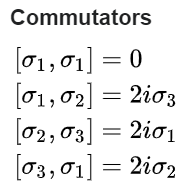

##### Where $\sigma_1 = X$, $\sigma_2 = Y$, $\sigma_3 = Z$. Note this table does not include $\sigma_0 = I$, which commutes with everything!
##### When comparing two Pauli strings $P_1 = \sigma^a_i \sigma^b_j ... \sigma^c_k$ and $P_2 = \sigma^{a'}_{i'} \sigma^{b'}_{j'} ... \sigma^{c'}_{k'}$ 
##### Simply check whether the Paulis acting on the same qubit commute. If all pairs commute then $P_1$ and $P_2$ commute! 
### If the commutator if two Pauli strings is 0, then they can be computed in parallel!